In [1]:
# %load_ext autoreload
# %autoreload 2
%load_ext lab_black

import os
import numpy as np
import pandas as pd
from glob import glob
import statsmodels.api as sm
from typing import List
import itertools
import matplotlib.pyplot as plt
from scipy import stats
import calpgs
from sklearn.model_selection import train_test_split
import seaborn as sns
from plot_utils import group_boxplot, lighten_boxplot
from tqdm import tqdm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

np.random.seed(42)
plt.rcParams["font.family"] = "Arial"

# Overview
We have genetic component $g$, environment component $e$, two covariates (one continuous, mimicking age, and one binary, mimicking sex) $c_1, c_2$ and their corresponding effects $\alpha_1, \alpha_2$. The phenotype is defined as $y = g + e + c_1 \alpha_1 + c_2 \alpha_2$. 

We assume that some PRS is derived $\hat{g}$, and it is assumed that $E[\hat{g} - g] = 0$. But for some reason, $\hat{g} \sim \mathcal{N}(g, \tau_0 + \tau_1 c_1 + \tau_2 c_2)$. Therefore, some differntial performance between $\hat{g}$ and $g$ across groups of individuals.


In [2]:
df_cov = pd.read_csv("data/cov.tsv", sep="\t", index_col=0).reset_index(drop=True)
n_indiv = df_cov.shape[0]
df_cov["GIA"] = np.sort(stats.expon.ppf(np.linspace(0.01, 0.4, n_indiv)))[
    stats.rankdata(df_cov["PC1"], method="ordinal") - 1
]
df_cov.drop(columns="PC1", inplace=True)

df_cov = (df_cov - df_cov.mean(axis=0)) / df_cov.std(axis=0)

In [3]:
def simulate_data(
    df_cov: pd.DataFrame,
    cov_effects: np.ndarray,
    baseline_r2: float,
    n_train=5000,
    n_test=5000,
    n_dummy=50,
):
    """
    Simulate phenotype, PRS, with the noise level as a function of covariates

    Parameters
    ----------
    n_indiv: int
        number of individuals
    baseline_r2: float
        R2 of PRS
    cov: np.ndarray
        covariates matrix
    cov_effects: np.ndarray
        1d vector covariate effects
    """
    # sub-sample covariates
    df_cov = df_cov.sample(n=n_train + n_test)
    cov = df_cov.values
    n_indiv = cov.shape[0]
    if not isinstance(cov_effects, np.ndarray):
        cov_effects = np.array(cov_effects)
    assert cov.shape[0] == n_indiv
    assert cov.shape[1] == len(cov_effects)
    pred = np.random.normal(size=n_indiv)

    design = np.hstack([np.ones((n_indiv, 1)), pred.reshape(-1, 1), cov])

    true_beta = np.array([0, 1] + [0] * cov.shape[1])
    true_gamma = np.array([np.log(1 / baseline_r2 - 1), 0] + list(cov_effects))
    y = np.random.normal(
        loc=design @ true_beta, scale=np.sqrt(np.exp(design @ true_gamma))
    )

    df_trait = pd.concat(
        [
            pd.DataFrame({"pred": pred, "y": y}, index=df_cov.index),
            df_cov,
        ],
        axis=1,
    )
    df_trait["predstd0"] = 1.0
    for col in ["AGE", "GIA", "SEX"]:
        n_unique = len(np.unique(df_trait[col]))
        if n_unique > 5:
            col_q = pd.qcut(df_trait[col], q=5).cat.codes
        else:
            col_q = pd.Categorical(df_trait[col]).codes
        df_trait[f"{col}_q"] = col_q

    # add dummy variable
    for i in range(n_dummy):
        df_trait[f"DUMMY{i}"] = np.random.normal(size=len(df_trait))
    df_train, df_test = train_test_split(df_trait, test_size=n_test, train_size=n_train)
    return df_train, df_test

In [4]:
# effects for age, sex, GIA
cov_effects = [0.25, 0.2, 0.15]
dict_data = {}
for n_calibrate in [100, 500, 2500, 5000]:
    for seed in range(50):
        np.random.seed(seed)
        df_train, df_test = simulate_data(
            df_cov=df_cov,
            cov_effects=cov_effects,
            baseline_r2=0.3,
            n_train=n_calibrate,
            n_test=5000,
        )
        dict_data[(n_calibrate, seed)] = df_train, df_test

# Compute experiment raw data

In [5]:
def evaluate_metrics(df_cal, df_test, adjust_cols):
    """
    Given a dataframe to perform calibration and testing, and columns to adjust
    report (1) coverage (2) R2

    # by default, adjust_cols = ["AGE", "SEX", "GIA"]
    """

    if adjust_cols is None:
        adjust_cols = []
    df_cal, df_test = df_cal.copy(), df_test.copy()

    dict_coverage = {}
    dict_r2 = {}

    train_y = df_cal["y"]
    train_x = sm.add_constant(df_cal[["pred"]])
    train_z = sm.add_constant(df_cal[adjust_cols])

    test_x = sm.add_constant(df_test[["pred"]])
    test_z = sm.add_constant(df_test[adjust_cols])

    # adjust
    res = calpgs.calibrate_and_adjust(
        train_x=train_x.values,
        train_z=train_z.values,
        train_y=train_y.values,
        test_x=test_x.values,
        test_z=test_z.values,
    )
    df_test["cal_pred"], df_test["cal_predstd"] = res[0:2]

    # evaluate
    for group_col in [None, "AGE_q", "GIA_q", "SEX_q"]:
        df_summary = calpgs.summarize_pred(
            df_test,
            y_col="y",
            pred_col="pred",
            predstd_col="cal_predstd",
            group_col=group_col,
        )
        if group_col is None:
            dict_coverage["marginal"] = df_summary["coverage"]
            dict_r2["marginal"] = df_summary["r2"]
        else:
            for i in df_summary.index:
                dict_coverage[f"{group_col}_{i}"] = df_summary["coverage"][i]
                dict_r2[f"{group_col}_{i}"] = df_summary["r2"][i]

    return pd.Series(dict_coverage), pd.Series(dict_r2)

In [6]:
dict_df_plot = dict()

for adjust in ["all", "none", "dummy5", "dummy25"]:
    if adjust == "all":
        adjust_cols = ["AGE", "SEX", "GIA"]
    elif adjust == "except-age":
        adjust_cols = ["SEX", "GIA"]
    elif adjust.startswith("dummy"):
        n_dummy = int(adjust.lstrip("dummy"))
        adjust_cols = ["AGE", "SEX", "GIA"] + [f"DUMMY{i}" for i in range(n_dummy)]
    elif adjust == "none":
        adjust_cols = None
    else:
        raise NotImplementedError
    dict_df_coverage = dict()
    dict_df_r2 = dict()

    for n_calibrate in tqdm([100, 500, 2500, 5000]):
        df_coverage = []
        df_r2 = []
        for seed in range(50):
            df_train, df_test = dict_data[(n_calibrate, seed)]
            tmp_cov, tmp_r2 = evaluate_metrics(
                df_train, df_test, adjust_cols=adjust_cols
            )
            df_coverage.append(tmp_cov)
            df_r2.append(tmp_r2)
        dict_df_coverage[n_calibrate] = pd.concat(df_coverage, axis=1).T
        dict_df_r2[n_calibrate] = pd.concat(df_r2, axis=1).T

    df_plot = {"n": [], "col": [], "coverage": [], "r2": []}

    for n in dict_df_coverage:
        for col in dict_df_coverage[n].columns:
            covs = dict_df_coverage[n][col].values
            df_plot["n"].extend([n] * len(covs))
            df_plot["col"].extend([col] * len(covs))
            df_plot["coverage"].extend(covs)
            df_plot["r2"].extend(dict_df_r2[n][col])

    df_plot = pd.DataFrame(df_plot)
    dict_df_plot[adjust] = df_plot

100%|██████████| 4/4 [00:16<00:00,  4.02s/it]


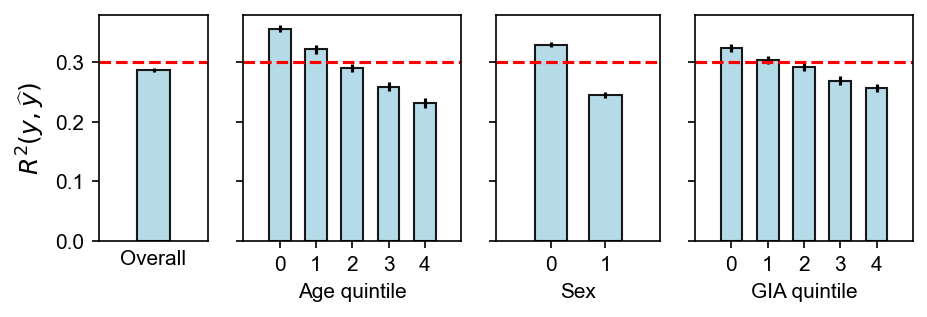

In [7]:
fig, axes = plt.subplots(
    figsize=(7, 2),
    dpi=150,
    ncols=4,
    sharey=True,
    gridspec_kw={"width_ratios": [1, 2, 1.5, 2]},
)

dict_cov_label = {
    "marginal": "Overall",
    "AGE_q": "Age quintile",
    "GIA_q": "GIA quintile",
    "SEX_q": "Sex",
}

for i, cov in enumerate(
    [
        "marginal",
        "AGE_q",
        "SEX_q",
        "GIA_q",
    ]
):
    df_tmp = dict_df_plot["none"].query("(n==5000)")
    r2 = df_tmp[df_tmp["col"].str.startswith(cov)].groupby("col").mean()["r2"].values
    r2_se = df_tmp[df_tmp["col"].str.startswith(cov)].groupby("col").sem()["r2"].values
    axes[i].bar(
        x=np.arange(len(r2)),
        height=r2,
        yerr=r2_se * 2,
        edgecolor="k",
        linewidth=1,
        alpha=0.9,
        color="lightblue",
        width=0.6,
    )
    axes[i].set_xlim(-1, len(r2))

    if cov == "marginal":
        axes[i].set_xticks([])
    else:
        axes[i].set_xticks(np.arange(len(r2)))
    axes[i].set_xlabel(dict_cov_label[cov])
    axes[i].axhline(y=0.3, ls="--", color="red")
axes[0].set_yticks([0, 0.1, 0.2, 0.3])
axes[0].set_ylabel("$R^2 (y, \widehat{y})$", fontsize=12)
plt.savefig("results/r2.pdf", bbox_inches="tight")

# Main figure

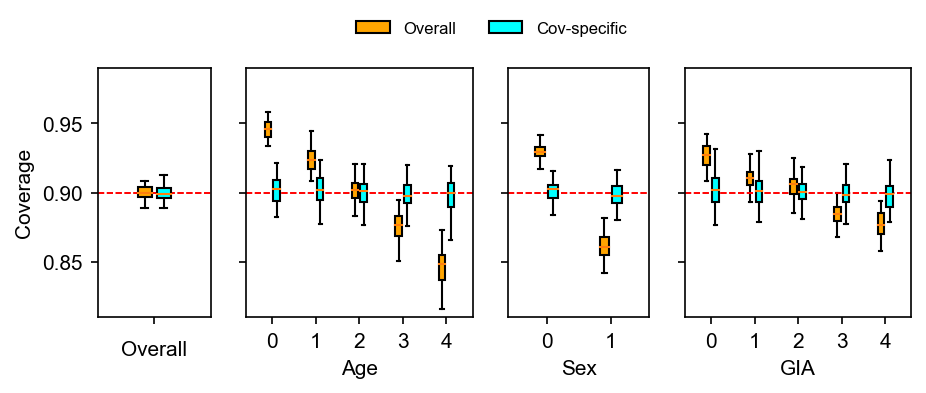

In [8]:
# overall calibration only

df_plot = dict_df_plot["none"].query("n == 5000").drop(columns=["n"])
df_plot["group"] = df_plot["col"].apply(lambda x: x.split("_")[0])
df_plot["group"] = df_plot["group"].replace(
    {"marginal": "Overall", "SEX": "Sex", "AGE": "Age"}
)
df_plot["subgroup"] = df_plot["col"].apply(
    lambda x: x.rsplit("_", 1)[1] if "_" in x else ""
)


fig, axes = plt.subplots(
    figsize=(7, 2.2),
    ncols=4,
    sharey=True,
    gridspec_kw={"width_ratios": np.array([1, 5, 2, 5]) + 3},
    dpi=150,
)


group_boxplot(
    df_plot,
    val_col="coverage",
    group_list=["Overall", "Age", "Sex", "GIA"],
    pos_offset=-0.1,
    axes=axes,
    color="orange",
)

# Covariate-specific calibration
df_plot = dict_df_plot["all"].query("n == 5000").drop(columns=["n"])
df_plot["group"] = df_plot["col"].apply(lambda x: x.split("_")[0])
df_plot["group"] = df_plot["group"].replace(
    {"marginal": "Overall", "SEX": "Sex", "AGE": "Age"}
)
df_plot["subgroup"] = df_plot["col"].apply(
    lambda x: x.rsplit("_", 1)[1] if "_" in x else ""
)

group_boxplot(
    df_plot,
    val_col="coverage",
    group_list=["Overall", "Age", "Sex", "GIA"],
    pos_offset=0.1,
    axes=axes,
    color="cyan",
)

axes[0].set_ylim(0.81, 0.99)


legend_elements = [
    Patch(facecolor="orange", edgecolor="k", label="Overall"),
    Patch(facecolor="cyan", edgecolor="k", label="Cov-specific"),
]

# Create the figure
fig.legend(
    handles=legend_elements,
    loc="center",
    ncol=2,
    bbox_to_anchor=(0.5, 1.0),
    fontsize=8,
    frameon=False,
)

# plt.savefig("results/main_coverage.pdf", bbox_inches="tight")

In [9]:
# effect of number of dummy variables to the calibration

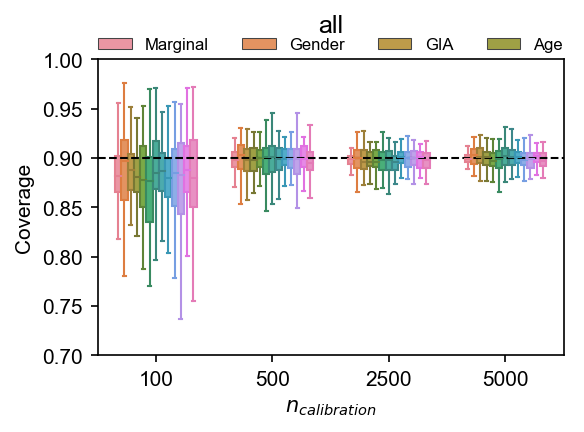

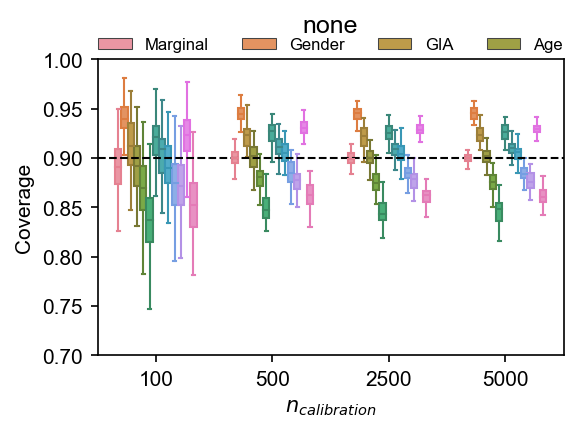

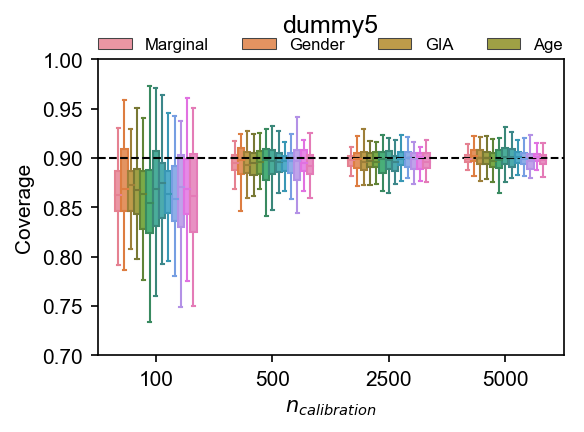

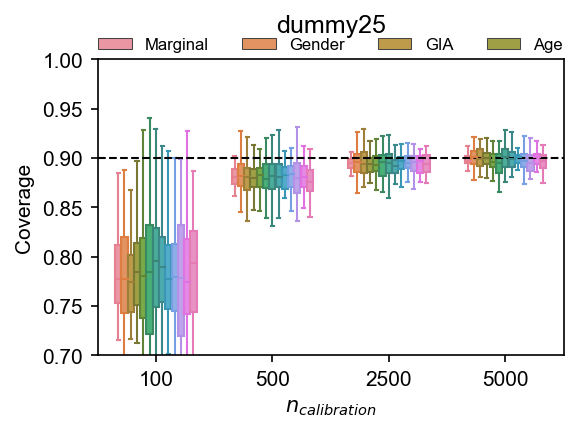

In [10]:
for adjust in dict_df_plot:
    df_plot = dict_df_plot[adjust]

    fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

    sns.boxplot(
        x="n",
        y="coverage",
        hue="col",
        width=0.7,
        linewidth=1.0,
        fliersize=0,
        data=df_plot,
        ax=ax,
    )

    ax.axhline(y=0.9, color="black", lw=1.0, ls="--")
    ax.set_xlabel("$n_{calibration}$")
    ax.set_ylabel("Coverage")

    lighten_boxplot(ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles,
        labels=[
            "Marginal",
            "Gender",
            "GIA",
            "Age",
        ],
        title=None,
        ncol=4,
        loc="center",
        bbox_to_anchor=(0.5, 1.05),
        fontsize=8,
        frameon=False,
    )
    ax.set_ylim(0.7, 1.0)
    ax.set_title(adjust, y=1.05)
    plt.tight_layout()

    plt.savefig(f"results/coverage_{adjust}.pdf", bbox_inches="tight")